# Practical Application III: Comparing Classifiers - Marketing Campaign Analysis

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



## Imports & Utilities

In [4]:
# CONSTANTS FOR THE PROJECT
class Config:
    RANDOM_STATE = 42
    SUPPRESS_OUTPUT_FILES=False
    PAGE_WIDTH = 10
    TARGET_COLORS = ('indianred', 'seagreen')
    # TARGET_COLORS = ('red', 'green')


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

# Export dataFrame's as images
import dataframe_image as dfi

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

In [6]:
# Configure logging
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%I:%M:%S %p')
# logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

# Switching logging config requires kernel restart - uncomment the test below to quickly verify settings
# logging.info("Logging output test")

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [7]:
def time_secs_to_msg(lapse_time_secs, mins_label='m', secs_label='s'):
    if lapse_time_secs <= 60:
        return f'{lapse_time_secs%60:.2f}{secs_label}'
    else:
        return f'{lapse_time_secs//60:,.0f}{mins_label} {lapse_time_secs%60:.2f}{secs_label}'

In [8]:
def build_results_row(name, model, Xtr, Xte, ytr, yte, use_best=False):
    """
    Given the model and training/test sets, builds a row of metrics for reporting the results

    :param name: Name/Description of model
    :param model: Fully constructed model instance - will call fit() and predict() to get metrics
    :param Xtr: X_train - scale before calling
    :param Xte: X_test - scale before calling
    :param ytr: Y_train set
    :param yteL: Y_test set
    """
    
    print(f'{name}: Starting', flush=True)
    start_time = time.time()

    # train the model
    clf = model.fit(Xtr, ytr)

    # if we're tuning then use best_estimator
    if use_best:
        clf = model.best_estimator_
        logging.debug(f'{name}: Best Model={clf}')
        logging.debug(f'{name}: Best Params={model.best_params_}')

    # Save fit time
    fit_time = time.time() - start_time
    logging.debug(f'{name}: Fitted')

    # get the predictions / probabilities
    y_preds = clf.predict(Xte)
    y_probs = clf.predict_proba(Xte)[:, 1]
    cm = confusion_matrix(yte, y_preds)
    logging.debug(f'{name}: Got preds/probs')

    # Get metrics
    row = {
        'Train Time': time_secs_to_msg(fit_time),
        'Train Accuracy': f'{model.score(Xtr, ytr)*100:.2f}%',
        'Test Accuracy': f'{model.score(Xte, yte)*100:.2f}%',
        'Precision': f'{precision_score(yte, y_preds)*100:.2f}%',
        'Recall': f'{recall_score(yte, y_preds)*100:.2f}%',
        'F1': f'{f1_score(yte, y_preds)*100:.2f}%',
        'AUC': f'{roc_auc_score(yte, y_probs)*100:.2f}%',
        'preds': y_preds,
        'probs': y_probs,
        'cm': cm,
        'TN': f'{cm[0, 0]:,d}',
        'FP': f'{cm[0, 1]:,d}',
        'FN': f'{cm[1, 0]:,d}',
        'TP': f'{cm[1, 1]:,d}',
        'best_params': None,
        'best_model': clf,
    }
    if use_best:
        row.update({'best_params': model.best_params_})
        
    logging.debug(f'{name}: Got metrics')
    
    print(f'{name}: Done: {time_secs_to_msg(time.time()-start_time)}')

    return row

## Exploratory Data Analysis (EDA)

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This data is a collection of results from 17 Direct Marketing (DM) phone campaign conducted by a Portugese Bank (Customer) between May 2008 and November 2010, corressponding to 79,354 contacts, who were offered attractive, long-term deposit applications. As you can see below, for each contact, various demographic and bank relationship attributes are provided. A separate column `y` has been provided showing whether the offer was accepted or not, i.e. was the capaign successful or not. We will now explore this data to develop an understanding of it's characteristics so that we can generate machine learning (ML) models to help the Customer optimize their future DM campaigns and improve the likelihood of the campaign offer being accepted. 

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [13]:
orig_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
# orig_df = pd.read_csv('data/bank-additional.csv', sep = ';')

In [14]:
orig_df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [16]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Inspect: Nulls

In [18]:
print('COMPLETENESS CHECK: Percent non-null values in each column')
orig_df.isnull().sum().transform(lambda x: (1 - (x / orig_df.shape[0])) * 100).round(2)

COMPLETENESS CHECK: Percent non-null values in each column


age               100.0
job               100.0
marital           100.0
education         100.0
default           100.0
housing           100.0
loan              100.0
contact           100.0
month             100.0
day_of_week       100.0
duration          100.0
campaign          100.0
pdays             100.0
previous          100.0
poutcome          100.0
emp.var.rate      100.0
cons.price.idx    100.0
cons.conf.idx     100.0
euribor3m         100.0
nr.employed       100.0
y                 100.0
dtype: float64

No nulls - looking good!

### Inspect: Overall Features

Let's take a quick look at the feature distributions to see if anything jumps out:

In [22]:
categorical_cols = orig_df.select_dtypes(include=['object']).columns
numerical_cols = orig_df.select_dtypes(exclude=['object']).columns.tolist()

06:32:25 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
06:32:26 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
06:32:26 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
06:32:26 PM INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


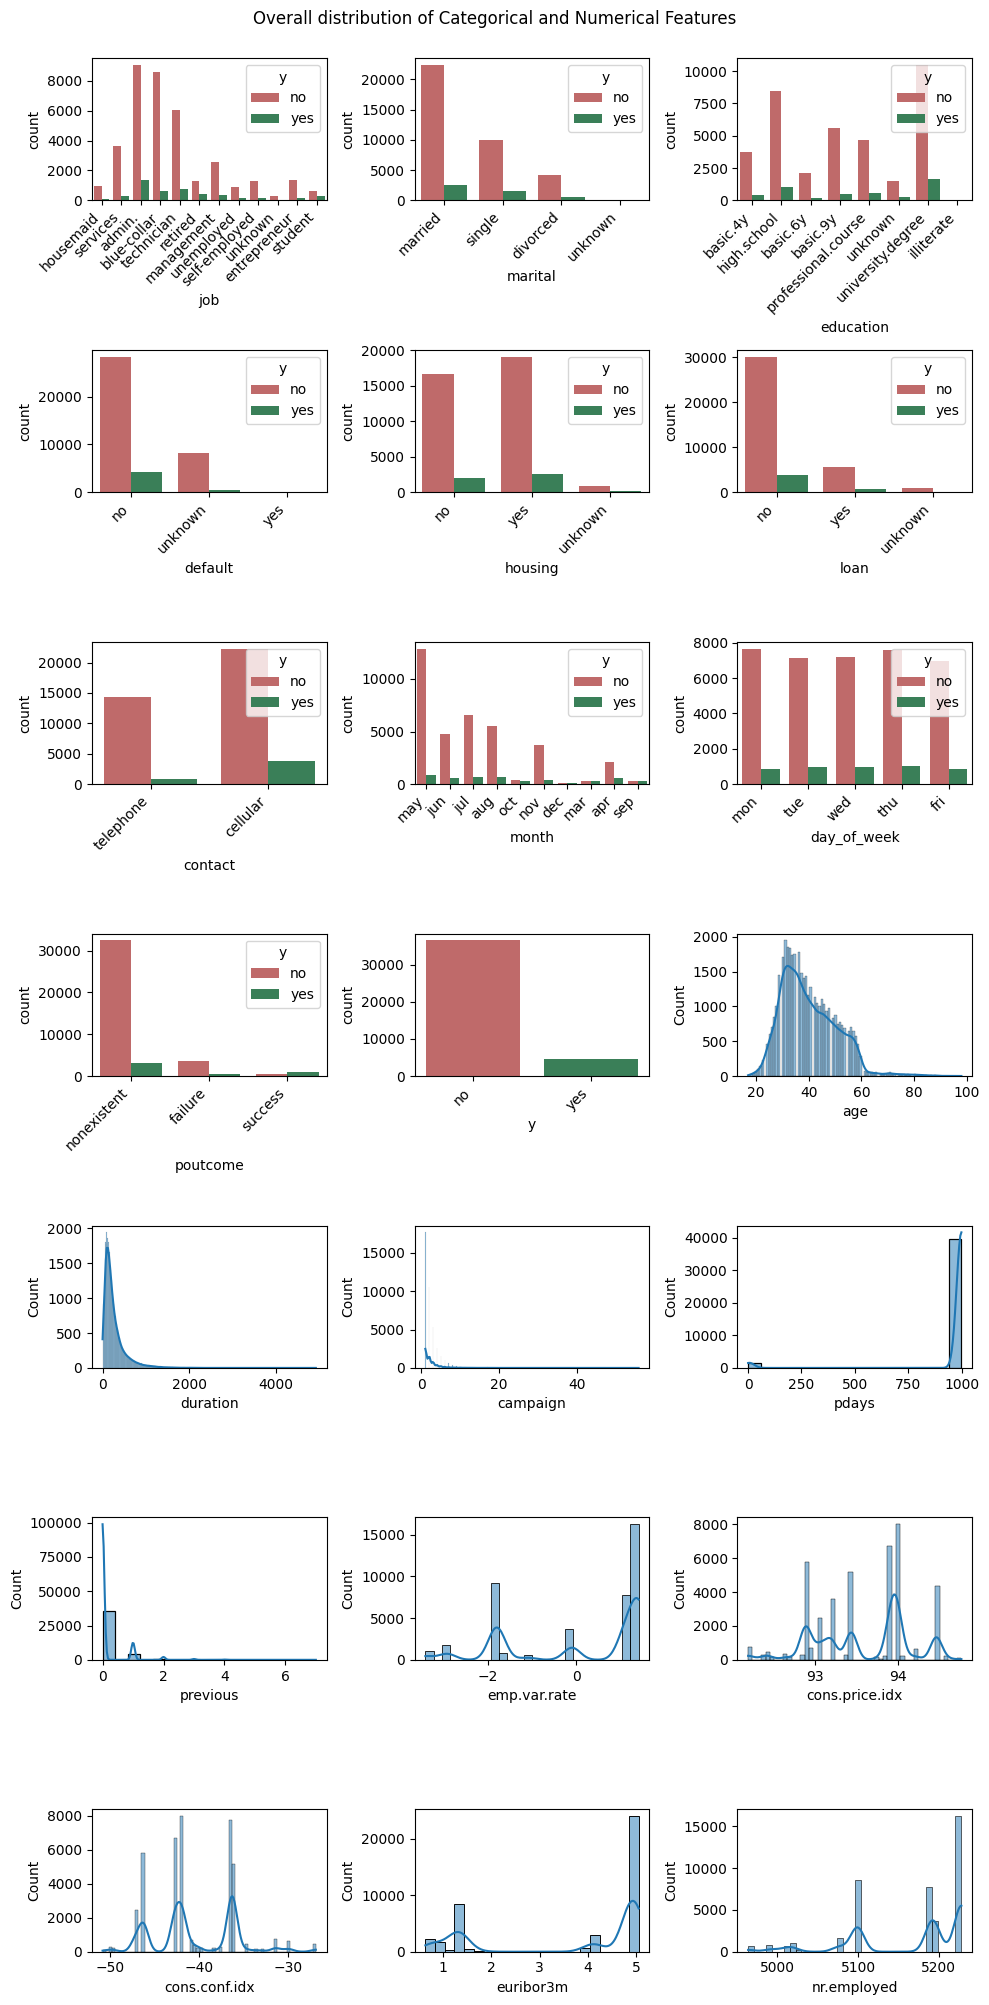

In [23]:
# plot all features in 3-columns format
cols = 3
rows = (len(categorical_cols) + len(numerical_cols)) // cols

fig, axes = plt.subplots(rows, cols, figsize=(Config.PAGE_WIDTH, 20))

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate countplots for each categorical feature
for i, col in enumerate(categorical_cols):
    sns.countplot(ax=axes[i], x=col, data=orig_df, hue='y', palette=Config.TARGET_COLORS)
    # axes[i].set_title(f'Countplot of {col}')
    # Rotate x-axis labels by 45 degrees
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

# Generate histograms for numerical features
for j, col in enumerate(numerical_cols, start=len(categorical_cols)):
    sns.histplot(orig_df[col], ax=axes[j], kde=True)
    # axes[j].set_title(f'Histogram of {col}')

# Hide any unused subplots
for k in range(len(categorical_cols) + len(numerical_cols), len(axes)):
    fig.delaxes(axes[k])

plt.suptitle('Overall distribution of Categorical and Numerical Features', y=1.0)

# Adjust layout to prevent overlap
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/feature_distributions.png')

plt.show()

We don't have any nulls and the overall distributions look reasonable - we can't exclude anything at this stage as it may be relevant for modeling.

Some data concerns that we can note for now and may have to come back to them:

* `unknown` values for `marital`, `default`, `housing` and `loan` columns: I'm ignoring them for now, but if these features are important during modeling, then we may have to understand the significance of these values. This is specially concerning for `default` cases where the `unknown` value is significant
* `pdays` distribution shows that majority of the resepondents were not previously contacted (999), so this may be a red flag for removing this column

### Inspect: Target = Campaign Acceptance 

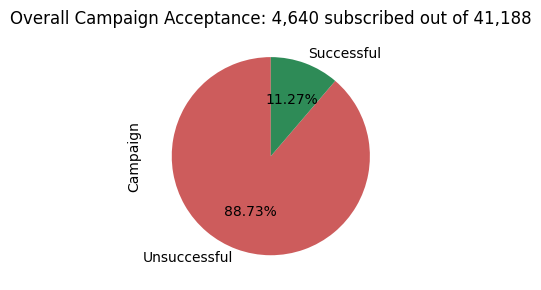

In [26]:
# Prep data for Pie chart
acceptance_rate_pie = orig_df.groupby('y')['y'].value_counts().rename('Campaign').reset_index()

# Calculate overall acceptance rate
nayes = acceptance_rate_pie.iloc[0, 1]
ayes = acceptance_rate_pie.iloc[1, 1]
acceptance_rate = (ayes / orig_df.shape[0]) * 100

names = ('Unsuccessful','Successful')
plt.rcParams['figure.figsize'] = (6,3)

acceptance_rate_pie.plot.pie(y='Campaign',
                             autopct='%1.2f%%', labels=names, legend=False,
                             colors=Config.TARGET_COLORS, startangle=90)
plt.title(f'Overall Campaign Acceptance: {ayes:,d} subscribed out of {orig_df.shape[0]:,d}')

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/pie-acceptance-overall.png')

plt.tight_layout()
plt.show()

### Inspect: Feature corelations

**To understand the feature correlations, I generated the Seaborn ``pairplot`` - it takes time to generate so the saved image is used instead**
```
sns.pairplot(orig_df, hue='y')

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/pairplot_raw_features.png')
    
plt.show()
```
![](images/pairplot_raw_features.png)

### Problem 4: Understanding the Task

**Business Objective**

This data is a collection of results from 17 Direct Marketing (DM) phone campaign conducted by a Portugese Bank (Customer) between May 2008 and November 2010, corressponding to 79,354 contacts, who were offered attractive, long-term deposit applications. As you can see below, for each contact, various demographic and bank relationship attributes are provided. A separate column `y` has been provided showing whether the offer was accepted or not, i.e. was the capaign successful or not. Our business objective is to help the Customer optimize their DM campagns in the future by predicting the likelihood of the campaign offer being accepted based on this data. 

In [30]:
orig_df.head(2)

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  

[2 rows x 21 columns]

## Data Modeling

### Problem 5: Engineering Features

Now that we understand our business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

Let's dig a little deeper - first we'll make a copy of the original data and transform it to aid our analysis:

In [34]:
encoded_df = orig_df.copy()

In [35]:
# Convert categorical variable to numeric data for the models to digest it
label_enc = LabelEncoder()
for col in categorical_cols:
    encoded_df[col] = label_enc.fit_transform(encoded_df[col])

Let's quickly check to see how our target variable looks against the other feature attributes for any red flags:

_To understand the feature correlations, I generated the Seaborn ``pairplot`` - it takes time to generate so the saved image is used instead_
```
sns.pairplot(encoded_df, hue='y', y_vars='y')

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/pairplot_raw_encoded_features_vs_y.png')
    
plt.show()
```
![](images/pairplot_raw_encoded_features_vs_y.png)

Let's look at the correlation among the variables:

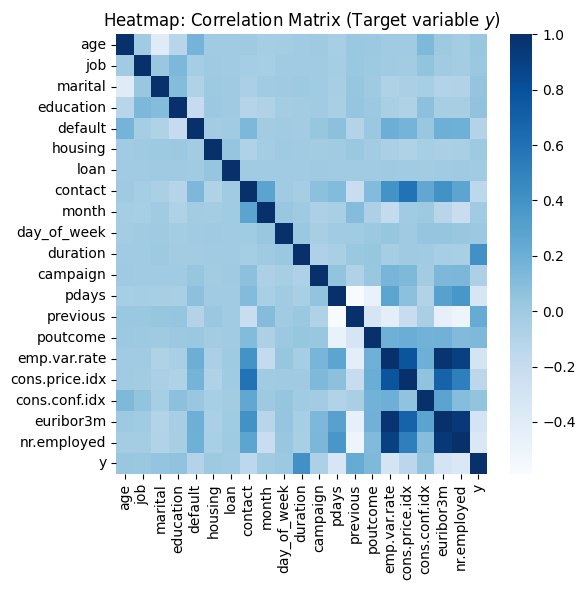

In [38]:
plt.figure(figsize=(6,6))
sns.heatmap(encoded_df.corr(), annot=False, cmap='Blues')

plt.title(f'Heatmap: Correlation Matrix (Target variable $y$)', y=1.0)
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/heatmap_cmatrix.png')
    
plt.show()

Most of the data seems to have reasonable correlations to the targe `y` variable - too early to eliminate any data till we get preliminary results from our models.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [41]:
# Create the feature matrices for independnet and target variables

X = encoded_df.drop('y', axis='columns')
y = encoded_df['y']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=Config.RANDOM_STATE)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat? We will use the Scikit ML Library provided `DummyClassifier` with `strategy='uniform'` that will make _untratined_ predictions with equal probability among the two possible classes: Successful and Unsuccessful, without taking any of the call features into account. 

In [44]:
logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [45]:
# Scale the data - we'll use StandardScaler for the baseline model
# scaler = StandardScaler()
scaler = MinMaxScaler()
logging.debug(f'Scaling data: {scaler}')

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

06:32:40 PM DEBUG: Scaling data: MinMaxScaler()


In [46]:
# let's start saving the results for reporting out
results_defaults = {}

# Reports won't print all the columns
report_cols = ['Train Time', 'Train Accuracy', 'Test Accuracy', 
               'Precision', 'Recall', 'F1', 'AUC', 'TN', 'FP', 'FN', 'TP']
report_cols_tuned = ['best_params', 'Train Time', 'Train Accuracy', 'Test Accuracy', 
                     'Precision', 'Recall', 'F1', 'AUC', 'TN', 'FP', 'FN', 'TP']

We are going to use a function `build_results_row` to build individual rows of our Model Report. Please see the Imports & Utililties section above for the source of this function:

In [48]:
help(build_results_row)

Help on function build_results_row in module __main__:

build_results_row(name, model, Xtr, Xte, ytr, yte, use_best=False)
    Given the model and training/test sets, builds a row of metrics for reporting the results
    
    :param name: Name/Description of model
    :param model: Fully constructed model instance - will call fit() and predict() to get metrics
    :param Xtr: X_train - scale before calling
    :param Xte: X_test - scale before calling
    :param ytr: Y_train set
    :param yteL: Y_test set



In [49]:
name = 'DummyClassifier'
model = DummyClassifier(strategy='uniform')

# Get metrics row for the report - will fit() and predict() to generate metrics
results_defaults[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)
results_df = pd.DataFrame(results_defaults).T

results_df.loc[name:][report_cols]

DummyClassifier: Starting


06:32:40 PM DEBUG: DummyClassifier: Fitted
06:32:40 PM DEBUG: DummyClassifier: Got preds/probs
06:32:41 PM DEBUG: DummyClassifier: Got metrics


DummyClassifier: Done: 0.43s


Train Time Train Accuracy Test Accuracy Precision  Recall  \
DummyClassifier      0.01s         50.41%        50.66%    10.98%  48.92%   

                     F1     AUC     TN     FP   FN   TP  
DummyClassifier  17.94%  50.00%  3,630  3,680  474  454

In [50]:
print(classification_report(y_test, results_defaults[name]['preds'], target_names=['Unsuccessful', 'Successful']))

              precision    recall  f1-score   support

Unsuccessful       0.88      0.50      0.64      7310
  Successful       0.11      0.49      0.18       928

    accuracy                           0.50      8238
   macro avg       0.50      0.49      0.41      8238
weighted avg       0.80      0.50      0.58      8238



As expected, the predictions from the DummyClassifier are about as good as a coin toss, and this is the baseline score for our business use case!

### Problem 8: A Simple Model

Let's try a linear regression model to see if we can do better!

In [53]:
name = 'LogisticRegression'
model = LogisticRegression()

# Get metrics row for the report - will fit() and predict() to generate metrics
results_defaults[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)
results_df = pd.DataFrame(results_defaults).T

results_df.loc[name:][report_cols]

LogisticRegression: Starting


06:32:42 PM DEBUG: LogisticRegression: Fitted
06:32:42 PM DEBUG: LogisticRegression: Got preds/probs
06:32:42 PM DEBUG: LogisticRegression: Got metrics


LogisticRegression: Done: 0.56s


Train Time Train Accuracy Test Accuracy Precision  Recall  \
LogisticRegression      0.48s         90.96%        91.64%    65.58%  54.20%   

                        F1     AUC     TN   FP   FN   TP  
LogisticRegression  59.35%  93.72%  7,046  264  425  503

### Problem 9: Score the Model

What is the accuracy of your model?

In [55]:
print(f'LogisticRegression Prediction Accuracy: {accuracy_score(y_test, results_defaults[name]["preds"]) * 100 :,.2f}%')

LogisticRegression Prediction Accuracy: 91.64%


In [56]:
print(classification_report(y_test, results_defaults[name]['preds'], target_names=['Unsuccessful', 'Successful']))

              precision    recall  f1-score   support

Unsuccessful       0.94      0.96      0.95      7310
  Successful       0.66      0.54      0.59       928

    accuracy                           0.92      8238
   macro avg       0.80      0.75      0.77      8238
weighted avg       0.91      0.92      0.91      8238



As we can see, the default `LogisticRegression` did much better out of the gate than the _dumb_ model, 50% vs over 90%! Let's see if we can do better now with more sophisticated models.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models by using the default settings of the models to fit and score each one.

In [59]:
# Define the default models
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC(probability=True)
}

for name, model in models.items():
    # Get metrics row for the report - will fit() and predict() to generate metrics
    results_defaults[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

KNeighborsClassifier: Starting


06:32:43 PM DEBUG: KNeighborsClassifier: Fitted
06:32:48 PM DEBUG: KNeighborsClassifier: Got preds/probs
06:33:00 PM DEBUG: KNeighborsClassifier: Got metrics


KNeighborsClassifier: Done: 16.97s
DecisionTreeClassifier: Starting


06:33:00 PM DEBUG: DecisionTreeClassifier: Fitted
06:33:00 PM DEBUG: DecisionTreeClassifier: Got preds/probs
06:33:00 PM DEBUG: DecisionTreeClassifier: Got metrics


DecisionTreeClassifier: Done: 0.31s
SVC: Starting


06:36:16 PM DEBUG: SVC: Fitted
06:36:35 PM DEBUG: SVC: Got preds/probs
06:37:26 PM DEBUG: SVC: Got metrics


SVC: Done: 4m 26.40s


In [60]:
results_defaults_df = pd.DataFrame(results_defaults).T.sort_values(by='Test Accuracy', ascending=False)

if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_defaults_df[report_cols], 'images/table_models_defaults.png')

results_defaults_df[report_cols]

06:37:35 PM DEBUG: STREAM b'IHDR' 16 13
06:37:35 PM DEBUG: STREAM b'iCCP' 41 296
06:37:35 PM DEBUG: iCCP profile name b'Skia'
06:37:35 PM DEBUG: Compression method 0
06:37:35 PM DEBUG: STREAM b'IDAT' 349 8192


Train Time Train Accuracy Test Accuracy Precision  \
LogisticRegression          0.48s         90.96%        91.64%    65.58%   
SVC                     3m 16.05s         90.44%        90.86%    71.50%   
KNeighborsClassifier        0.02s         91.43%        89.49%    56.77%   
DecisionTreeClassifier      0.26s        100.00%        86.47%    42.98%   
DummyClassifier             0.01s         50.41%        50.66%    10.98%   

                        Recall      F1     AUC     TN     FP   FN   TP  
LogisticRegression      54.20%  59.35%  93.72%  7,046    264  425  503  
SVC                     31.36%  43.60%  93.61%  7,194    116  637  291  
KNeighborsClassifier    28.02%  37.52%  78.10%  7,112    198  668  260  
DecisionTreeClassifier  61.64%  50.64%  75.63%  6,551    759  356  572  
DummyClassifier         48.92%  17.94%  50.00%  3,630  3,680  474  454

We can now compare the results from all our base Models! The best performing model with the highest Test Accuracy Score on the validation data is `SVC`, i.e. after being trained on the training data, how it does against the held-out test dataset in correctly predicting the offer acceptance (both positive and negative) across all calls.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree 
- Adjust our performance metrics

In [63]:
# Define the models to be tuned
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC(probability=True, max_iter=10000)
}

param_grid = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
    },
    
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    'SVC': {
        # 'C': [0.1, 1, 10, 100],
        'C': np.logspace(-3, 4, 5).round(4),
        'kernel': ['linear', 'poly', 'rbf'],
        'degree': [1, 3],    # For poly only - 5 didn't win
        'gamma': ['scale', 'auto'],
    }
}

In [64]:
np.logspace(-3, 4, 5).round(4)

array([1.000000e-03, 5.620000e-02, 3.162300e+00, 1.778279e+02,
       1.000000e+04])

In [65]:
# Perform GridSearchCV
CV=5
VERBOSE=3
results_tuned = {}

for name, model in models.items():
    
    print(f'{name}: Starting GridSearchCV optimization ({CV}-fold)', flush=True)
    grid_search = GridSearchCV(model, param_grid=param_grid[name], scoring='accuracy',
                              cv=CV, verbose=VERBOSE)
    
    results_tuned[name] = build_results_row(name, grid_search, X_train_scaled, X_test_scaled, y_train, y_test, use_best=True)
    print(f'{name}: Done GridSearchCV optimization ({CV}-fold)', flush=True)

LogisticRegression: Starting GridSearchCV optimization (5-fold)
LogisticRegression: Starting
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.849 total time=   1.2s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.847 total time=   2.3s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.836 total time=   3.0s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.841 total time=   2.4s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.847 total time=   0.7s
[CV 1/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.846 total time=   0.3s
[CV 2/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.841 total time=   0.3s
[CV 3/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.828 total time=   0.2s
[CV 4/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.835 total time=   0.3s
[CV 5/5] END ...C=0.01, penalty=l1, solver=saga;, score=0.838 total time=   0.3s
[CV 1/5] END C=0.01, penal

06:40:10 PM DEBUG: LogisticRegression: Best Model=LogisticRegression(C=1, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='saga')
06:40:10 PM DEBUG: LogisticRegression: Best Params={'C': 1, 'penalty': 'l1', 'solver': 'saga'}
06:40:10 PM DEBUG: LogisticRegression: Fitted
06:40:10 PM DEBUG: LogisticRegression: Got preds/probs
06:40:10 PM DEBUG: LogisticRegression: Got metrics


LogisticRegression: Done: 2m 33.99s
LogisticRegression: Done GridSearchCV optimization (5-fold)
KNeighborsClassifier: Starting GridSearchCV optimization (5-fold)
KNeighborsClassifier: Starting
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.889 total time=   0.8s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.892 total time=   0.8s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.886 total time=   0.9s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.882 total time=   0.9s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.883 total time=   1.3s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.887 total time=   2.3s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.891 total time=   1.2s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.881 total time=   1.7

06:50:24 PM DEBUG: KNeighborsClassifier: Best Model=KNeighborsClassifier(n_neighbors=11)
06:50:24 PM DEBUG: KNeighborsClassifier: Best Params={'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'uniform'}
06:50:24 PM DEBUG: KNeighborsClassifier: Fitted


[CV 5/5] END algorithm=brute, n_neighbors=11, weights=distance;, score=0.895 total time=   0.7s


06:50:27 PM DEBUG: KNeighborsClassifier: Got preds/probs
06:50:34 PM DEBUG: KNeighborsClassifier: Got metrics


KNeighborsClassifier: Done: 10m 23.62s
KNeighborsClassifier: Done GridSearchCV optimization (5-fold)
DecisionTreeClassifier: Starting GridSearchCV optimization (5-fold)
DecisionTreeClassifier: Starting
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.891 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.891 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.882 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.890 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.881 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5;, score=0.891 total time=   0.2s
[CV 2/5] END criterion=gini,

06:51:17 PM DEBUG: DecisionTreeClassifier: Best Model=DecisionTreeClassifier(max_depth=10, min_samples_leaf=4)
06:51:17 PM DEBUG: DecisionTreeClassifier: Best Params={'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
06:51:17 PM DEBUG: DecisionTreeClassifier: Fitted
06:51:17 PM DEBUG: DecisionTreeClassifier: Got preds/probs
06:51:17 PM DEBUG: DecisionTreeClassifier: Got metrics


DecisionTreeClassifier: Done: 43.59s
DecisionTreeClassifier: Done GridSearchCV optimization (5-fold)
SVC: Starting GridSearchCV optimization (5-fold)
SVC: Starting
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.887 total time=  57.0s
[CV 2/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.887 total time=  55.4s
[CV 3/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.887 total time=  54.3s
[CV 4/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.887 total time=  53.3s
[CV 5/5] END C=0.001, degree=1, gamma=scale, kernel=linear;, score=0.887 total time=  53.9s
[CV 1/5] END C=0.001, degree=1, gamma=scale, kernel=poly;, score=0.887 total time= 1.1min
[CV 2/5] END C=0.001, degree=1, gamma=scale, kernel=poly;, score=0.887 total time=  59.7s
[CV 3/5] END C=0.001, degree=1, gamma=scale, kernel=poly;, score=0.887 total time= 1.1min
[CV 4/5] END C=0.001, degree=1, gamma=scale,

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1623, degree=1, gamma=scale, kernel=linear;, score=0.902 total time=  52.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=1, gamma=scale, kernel=linear;, score=0.900 total time=  53.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1623, degree=1, gamma=scale, kernel=linear;, score=0.894 total time=  51.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=1, gamma=scale, kernel=linear;, score=0.897 total time=  51.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=1, gamma=scale, kernel=linear;, score=0.897 total time=  54.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1623, degree=1, gamma=scale, kernel=poly;, score=0.901 total time=  55.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=1, gamma=scale, kernel=poly;, score=0.900 total time=  53.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1623, degree=1, gamma=scale, kernel=poly;, score=0.893 total time=  54.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=1, gamma=scale, kernel=poly;, score=0.897 total time=  53.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=1, gamma=scale, kernel=poly;, score=0.897 total time=  54.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1623, degree=1, gamma=scale, kernel=rbf;, score=0.905 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=1, gamma=scale, kernel=rbf;, score=0.905 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1623, degree=1, gamma=scale, kernel=rbf;, score=0.901 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=1, gamma=scale, kernel=rbf;, score=0.906 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=1, gamma=scale, kernel=rbf;, score=0.907 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1623, degree=1, gamma=auto, kernel=linear;, score=0.902 total time=  52.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=1, gamma=auto, kernel=linear;, score=0.900 total time=  59.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1623, degree=1, gamma=auto, kernel=linear;, score=0.894 total time=  51.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=1, gamma=auto, kernel=linear;, score=0.897 total time=  52.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=1, gamma=auto, kernel=linear;, score=0.897 total time=  51.7s
[CV 1/5] END C=3.1623, degree=1, gamma=auto, kernel=poly;, score=0.900 total time=  56.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=1, gamma=auto, kernel=poly;, score=0.900 total time=  55.2s
[CV 3/5] END C=3.1623, degree=1, gamma=auto, kernel=poly;, score=0.893 total time=  57.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=1, gamma=auto, kernel=poly;, score=0.897 total time=  54.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=1, gamma=auto, kernel=poly;, score=0.897 total time=  56.0s
[CV 1/5] END C=3.1623, degree=1, gamma=auto, kernel=rbf;, score=0.901 total time= 1.2min
[CV 2/5] END C=3.1623, degree=1, gamma=auto, kernel=rbf;, score=0.901 total time= 1.2min
[CV 3/5] END C=3.1623, degree=1, gamma=auto, kernel=rbf;, score=0.895 total time= 1.2min
[CV 4/5] END C=3.1623, degree=1, gamma=auto, kernel=rbf;, score=0.899 total time= 1.2min
[CV 5/5] END C=3.1623, degree=1, gamma=auto, kernel=rbf;, score=0.899 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1623, degree=3, gamma=scale, kernel=linear;, score=0.902 total time=  51.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=3, gamma=scale, kernel=linear;, score=0.900 total time=  54.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1623, degree=3, gamma=scale, kernel=linear;, score=0.894 total time=  51.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=3, gamma=scale, kernel=linear;, score=0.897 total time=  52.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=3, gamma=scale, kernel=linear;, score=0.897 total time=  54.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1623, degree=3, gamma=scale, kernel=poly;, score=0.907 total time= 1.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=3, gamma=scale, kernel=poly;, score=0.906 total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1623, degree=3, gamma=scale, kernel=poly;, score=0.902 total time= 1.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=3, gamma=scale, kernel=poly;, score=0.907 total time=  59.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=3, gamma=scale, kernel=poly;, score=0.909 total time= 1.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1623, degree=3, gamma=scale, kernel=rbf;, score=0.905 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=3, gamma=scale, kernel=rbf;, score=0.905 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1623, degree=3, gamma=scale, kernel=rbf;, score=0.901 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=3, gamma=scale, kernel=rbf;, score=0.906 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=3, gamma=scale, kernel=rbf;, score=0.907 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=3.1623, degree=3, gamma=auto, kernel=linear;, score=0.902 total time=  53.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=3.1623, degree=3, gamma=auto, kernel=linear;, score=0.900 total time=  53.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=3.1623, degree=3, gamma=auto, kernel=linear;, score=0.894 total time=  51.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=3.1623, degree=3, gamma=auto, kernel=linear;, score=0.897 total time=  52.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=3.1623, degree=3, gamma=auto, kernel=linear;, score=0.897 total time=  53.7s
[CV 1/5] END C=3.1623, degree=3, gamma=auto, kernel=poly;, score=0.898 total time= 1.0min
[CV 2/5] END C=3.1623, degree=3, gamma=auto, kernel=poly;, score=0.900 total time= 1.0min
[CV 3/5] END C=3.1623, degree=3, gamma=auto, kernel=poly;, score=0.895 total time= 1.0min
[CV 4/5] END C=3.1623, degree=3, gamma=auto, kernel=poly;, score=0.898 total time= 1.0min
[CV 5/5] END C=3.1623, degree=3, gamma=auto, kernel=poly;, score=0.898 total time= 1.1min
[CV 1/5] END C=3.1623, degree=3, gamma=auto, kernel=rbf;, score=0.901 total time= 1.2min
[CV 2/5] END C=3.1623, degree=3, gamma=auto, kernel=rbf;, score=0.901 total time= 1.2min
[CV 3/5] END C=3.1623, degree=3, gamma=auto, kernel=rbf;, score=0.895 total time= 1.2min
[CV 4/5] END C=3.1623, degree=3, gamma=auto, kernel=rbf;, score=0.899 total time= 1.2min
[CV 5/5] END C=3.1623, degree=3, gamma=auto, kernel=rbf;, score=0.899 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=1, gamma=scale, kernel=linear;, score=0.591 total time=  48.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=1, gamma=scale, kernel=linear;, score=0.527 total time=  46.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=1, gamma=scale, kernel=linear;, score=0.445 total time=  46.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=1, gamma=scale, kernel=linear;, score=0.370 total time=  48.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=1, gamma=scale, kernel=linear;, score=0.438 total time=  48.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=1, gamma=scale, kernel=poly;, score=0.638 total time=  53.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=1, gamma=scale, kernel=poly;, score=0.524 total time=  55.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=1, gamma=scale, kernel=poly;, score=0.785 total time=  52.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=1, gamma=scale, kernel=poly;, score=0.802 total time=  52.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=1, gamma=scale, kernel=poly;, score=0.705 total time=  53.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=1, gamma=scale, kernel=rbf;, score=0.887 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=1, gamma=scale, kernel=rbf;, score=0.812 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=1, gamma=scale, kernel=rbf;, score=0.877 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=1, gamma=scale, kernel=rbf;, score=0.854 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=1, gamma=scale, kernel=rbf;, score=0.869 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=1, gamma=auto, kernel=linear;, score=0.591 total time=  47.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=1, gamma=auto, kernel=linear;, score=0.527 total time=  46.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=1, gamma=auto, kernel=linear;, score=0.445 total time=  46.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=1, gamma=auto, kernel=linear;, score=0.370 total time=  46.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=1, gamma=auto, kernel=linear;, score=0.438 total time=  47.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=1, gamma=auto, kernel=poly;, score=0.906 total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=1, gamma=auto, kernel=poly;, score=0.906 total time= 1.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=1, gamma=auto, kernel=poly;, score=0.898 total time=  58.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=1, gamma=auto, kernel=poly;, score=0.903 total time=  58.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=1, gamma=auto, kernel=poly;, score=0.902 total time= 1.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=1, gamma=auto, kernel=rbf;, score=0.907 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=1, gamma=auto, kernel=rbf;, score=0.909 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=1, gamma=auto, kernel=rbf;, score=0.904 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=1, gamma=auto, kernel=rbf;, score=0.907 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=1, gamma=auto, kernel=rbf;, score=0.912 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=3, gamma=scale, kernel=linear;, score=0.591 total time=  47.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=3, gamma=scale, kernel=linear;, score=0.527 total time=  47.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=3, gamma=scale, kernel=linear;, score=0.445 total time=  45.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=3, gamma=scale, kernel=linear;, score=0.370 total time=  49.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=3, gamma=scale, kernel=linear;, score=0.438 total time=  46.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=3, gamma=scale, kernel=poly;, score=0.660 total time=  55.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=3, gamma=scale, kernel=poly;, score=0.746 total time=  56.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=3, gamma=scale, kernel=poly;, score=0.590 total time=  53.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=3, gamma=scale, kernel=poly;, score=0.556 total time=  54.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=3, gamma=scale, kernel=poly;, score=0.498 total time=  56.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=3, gamma=scale, kernel=rbf;, score=0.887 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=3, gamma=scale, kernel=rbf;, score=0.812 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=3, gamma=scale, kernel=rbf;, score=0.877 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=3, gamma=scale, kernel=rbf;, score=0.854 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=3, gamma=scale, kernel=rbf;, score=0.869 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=3, gamma=auto, kernel=linear;, score=0.591 total time=  46.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=3, gamma=auto, kernel=linear;, score=0.527 total time=  46.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=3, gamma=auto, kernel=linear;, score=0.445 total time=  45.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=3, gamma=auto, kernel=linear;, score=0.370 total time=  47.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=3, gamma=auto, kernel=linear;, score=0.438 total time=  48.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=3, gamma=auto, kernel=poly;, score=0.904 total time=  56.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=3, gamma=auto, kernel=poly;, score=0.905 total time=  58.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=3, gamma=auto, kernel=poly;, score=0.900 total time=  56.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=3, gamma=auto, kernel=poly;, score=0.905 total time=  57.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=3, gamma=auto, kernel=poly;, score=0.905 total time=  59.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=177.8279, degree=3, gamma=auto, kernel=rbf;, score=0.907 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=177.8279, degree=3, gamma=auto, kernel=rbf;, score=0.909 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=177.8279, degree=3, gamma=auto, kernel=rbf;, score=0.904 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=177.8279, degree=3, gamma=auto, kernel=rbf;, score=0.907 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=177.8279, degree=3, gamma=auto, kernel=rbf;, score=0.912 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.218 total time=  38.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.525 total time=  39.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.564 total time=  38.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.748 total time=  40.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=scale, kernel=linear;, score=0.582 total time=  41.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.656 total time=  41.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.726 total time=  43.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.578 total time=  44.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.259 total time=  42.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=scale, kernel=poly;, score=0.552 total time=  44.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.515 total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.776 total time= 1.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.653 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.620 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=scale, kernel=rbf;, score=0.606 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.218 total time=  43.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.525 total time=  45.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.564 total time=  45.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.748 total time=  44.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=auto, kernel=linear;, score=0.582 total time=  44.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.510 total time=  58.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.415 total time=  59.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.675 total time=  52.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.486 total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=auto, kernel=poly;, score=0.636 total time=  53.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.418 total time= 1.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.568 total time= 1.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.511 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.692 total time= 1.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=1, gamma=auto, kernel=rbf;, score=0.565 total time= 1.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.218 total time=  38.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.525 total time=  39.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.564 total time=  43.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.748 total time=  40.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=scale, kernel=linear;, score=0.582 total time=  38.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.682 total time=  47.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.665 total time=  49.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.634 total time=  46.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.652 total time=  49.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=scale, kernel=poly;, score=0.574 total time=  47.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.515 total time= 1.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.776 total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.653 total time= 1.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.620 total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=scale, kernel=rbf;, score=0.606 total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.218 total time=  37.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.525 total time=  38.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.564 total time=  42.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.748 total time=  39.6s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=auto, kernel=linear;, score=0.582 total time=  38.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.731 total time= 1.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.627 total time=  57.8s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.784 total time=  57.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.707 total time=  59.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=auto, kernel=poly;, score=0.738 total time=  58.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.418 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.568 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.511 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.692 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=10000.0, degree=3, gamma=auto, kernel=rbf;, score=0.565 total time= 1.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
11:56:39 PM DEBUG: SVC: Best Model=SVC(C=177.8279, degree=1, gamma='auto', max_iter=10000, probability=True)
11:56:39 PM DEBUG: SVC: Best Params={'C': 177.8279, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}
11:56:39 PM DEBUG: SVC: Fitted
11:56:50 PM DEBUG: SVC: Got preds/probs
11:57:20 PM DEBUG: SVC: Got metrics


SVC: Done: 306m 3.14s
SVC: Done GridSearchCV optimization (5-fold)


In [66]:
# Print results for the best-model selected by GridSearchCV
best_model = grid_search.best_estimator_
best_model_idx = [name for name, model in models.items() if results_tuned[name]['best_model'] == best_model][0]

print('Best Model: {}\n\n{}'
      .format(best_model, classification_report(y_test, results_tuned['SVC']['preds'], target_names=['Unsuccessful', 'Successful'])),
      flush=True
     )

Best Model: SVC(C=177.8279, degree=1, gamma='auto', max_iter=10000, probability=True)

              precision    recall  f1-score   support

Unsuccessful       0.94      0.96      0.95      7310
  Successful       0.62      0.56      0.59       928

    accuracy                           0.91      8238
   macro avg       0.78      0.76      0.77      8238
weighted avg       0.91      0.91      0.91      8238



In [67]:
results_tuned_df = pd.DataFrame(results_tuned).T.sort_values(by='Test Accuracy', ascending=False)
results_tuned_df_styled = results_tuned_df[report_cols_tuned]
# results_tuned_df_styled = results_tuned_df_styled.style.set_properties(subset=['best_params'], **{'white-space': 'pre-wrap'})
results_tuned_df_styled = results_tuned_df_styled.style.set_table_styles(
    [{'selector': 'td', 'props': [('max-width', '150px'), 
                                  ('white-space', 'normal'), 
                                  ('word-wrap', 'break-word')]}]
)

if not Config.SUPPRESS_OUTPUT_FILES:  
    dfi.export(results_tuned_df_styled, 'images/table_models_tuned.png')

results_tuned_df_styled

11:57:27 PM DEBUG: STREAM b'IHDR' 16 13
11:57:27 PM DEBUG: STREAM b'iCCP' 41 300
11:57:27 PM DEBUG: iCCP profile name b'Skia'
11:57:27 PM DEBUG: Compression method 0
11:57:27 PM DEBUG: STREAM b'IDAT' 353 8192


In [68]:
results_defaults_df[report_cols]

Train Time Train Accuracy Test Accuracy Precision  \
LogisticRegression          0.48s         90.96%        91.64%    65.58%   
SVC                     3m 16.05s         90.44%        90.86%    71.50%   
KNeighborsClassifier        0.02s         91.43%        89.49%    56.77%   
DecisionTreeClassifier      0.26s        100.00%        86.47%    42.98%   
DummyClassifier             0.01s         50.41%        50.66%    10.98%   

                        Recall      F1     AUC     TN     FP   FN   TP  
LogisticRegression      54.20%  59.35%  93.72%  7,046    264  425  503  
SVC                     31.36%  43.60%  93.61%  7,194    116  637  291  
KNeighborsClassifier    28.02%  37.52%  78.10%  7,112    198  668  260  
DecisionTreeClassifier  61.64%  50.64%  75.63%  6,551    759  356  572  
DummyClassifier         48.92%  17.94%  50.00%  3,630  3,680  474  454

Optimizations:

* Switch to MinMaxScaler
* Tuned max_iter, C, poly/degree
* LR: class_weight = balanced

FE: remove housing, loan

#### Confusion Matrices

11:57:28 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x12d2b2d50>
11:57:28 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x12d340bd0>
11:57:28 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x1354eed90>
11:57:28 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x135536490>
11:57:28 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x12d288c10>
11:57:28 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x1355eba50>
11:57:28 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x12bd5af50>
11:57:28 PM DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x13568de90>


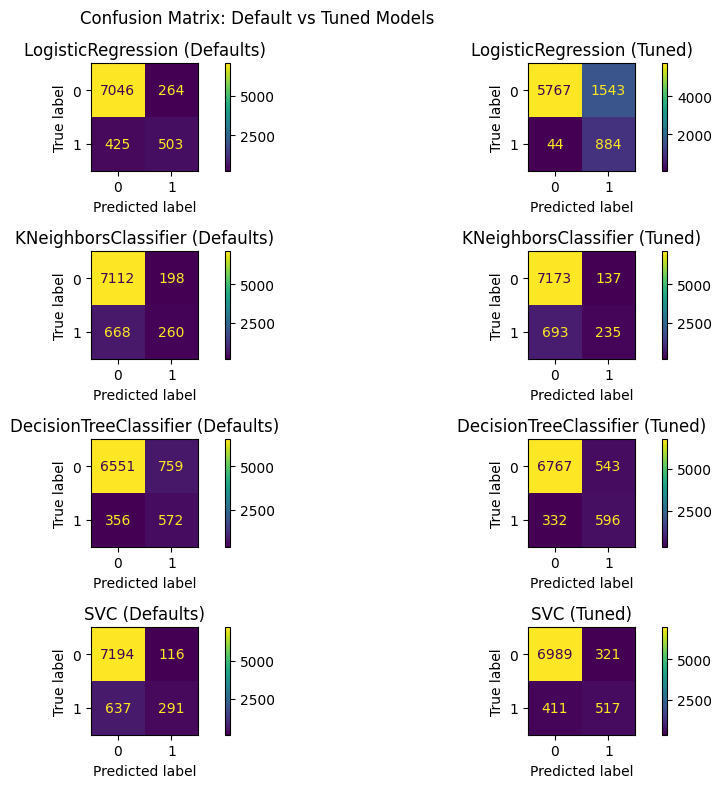

In [72]:
# Plot the default and tuned confusion matrices side-by-side

fig, axes = plt.subplots(4, 2, figsize=(Config.PAGE_WIDTH, 8))
fig.suptitle('Confusion Matrix: Default vs Tuned Models')

row = 0
for name, model in models.items():
    
    # Get the CM from the results for left and right views
    cm_l = results_defaults[name]['cm']
    cm_r = results_tuned[name]['cm']

    # Get the CM
    disp_l = ConfusionMatrixDisplay(cm_l)#, display_labels=['Unsuccessful', 'Successful'])
    disp_r = ConfusionMatrixDisplay(cm_r)#, display_labels=['Unsuccessful', 'Successful'])

    # plot CM
    disp_l.plot(ax=axes[row,0])
    disp_r.plot(ax=axes[row,1])

    axes[row,0].set_title(f'{name} (Defaults)')
    axes[row,1].set_title(f'{name} (Tuned)')

    row += 1

plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:  
    plt.savefig('images/confusion_matrices.png')
    
plt.show()

#### ROC Curves

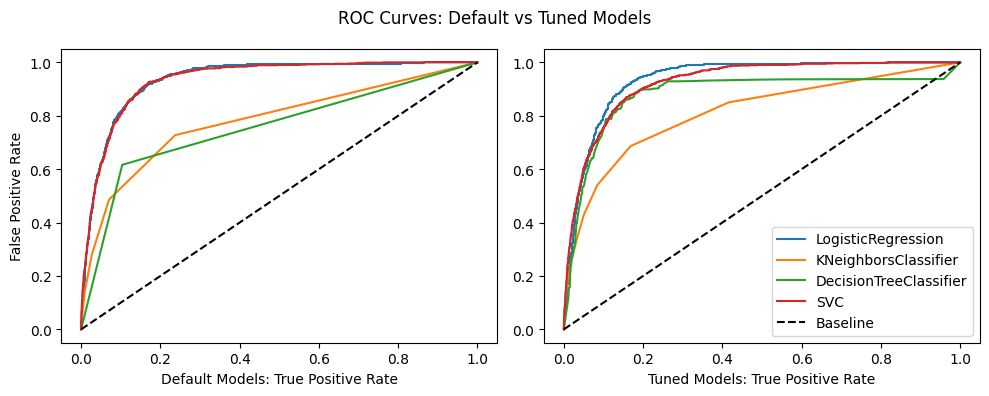

In [74]:
fig, axes = plt.subplots(1,2, figsize=(Config.PAGE_WIDTH, 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# plt.figure()
for name, model in models.items():
    probs_l = results_defaults[name]['probs']
    probs_r = results_tuned[name]['probs']
    fpr_l, tpr_l, threshold_l = roc_curve(y_test, probs_l)
    fpr_r, tpr_r, threshold_r = roc_curve(y_test, probs_r)
    axes[0].plot(fpr_l, tpr_l, label=name)
    axes[1].plot(fpr_r, tpr_r, label=name)

# Add the Baseline
axes[0].plot([0, 1], [0, 1], 'k--', label='Baseline')
axes[1].plot([0, 1], [0, 1], 'k--', label='Baseline')

axes[0].set_ylabel("False Positive Rate")
axes[0].set_xlabel("Default Models: True Positive Rate")
axes[1].set_xlabel("Tuned Models: True Positive Rate")
plt.suptitle("ROC Curves: Default vs Tuned Models")
plt.legend(loc="best")

plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:  
    plt.savefig('images/roc_curves.png')

plt.show()

#### Feature Importance

In [76]:
def plot_single_feature_importance(clf_name, feature_imps, feature_names, 
                                   top_n=0, print_summary=True, ax=None):
    """
    Given feature importances for a single model, renders it as a bar graph on the given axes. Called by main 
    plotting code to render a single subplot

    :param clf_name: Name of model used in title
    :param feature_imps: Feature importance array to plot - sorts it
    :param feature_names: Name of features for y-axis
    :param top_n: How many top features to graph
    :param print_summary: Control printing table of the features
    :param ax: Axes for subplot
    """
        
    # Normalize the feature importances
    feature_importances = feature_imps / feature_imps.sum()
    
    # Create a DataFrame with feature names and importances
    importance_summary = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_summary = importance_summary.sort_values('Importance', ascending=False).reset_index(drop=True)

    # Display the top 10 most important features
    title=f'{clf_name}'
    if top_n > 0:
        title=f'{clf_name}: Top {top_n} Important Features'
        imp_table = importance_summary.head(top_n)
    else:
        imp_table = importance_summary

    if print_summary:
        print(title)
        print(imp_table)
    
    # Visualize feature importances
    ax.barh(imp_table['Feature'][:10], imp_table['Importance'][:10])#, color='skyblue')
    # ax.set_xlabel('Feature Importance')
    ax.set_title(title)
    ax.invert_yaxis()  # Invert y-axis to have the most important feature on top

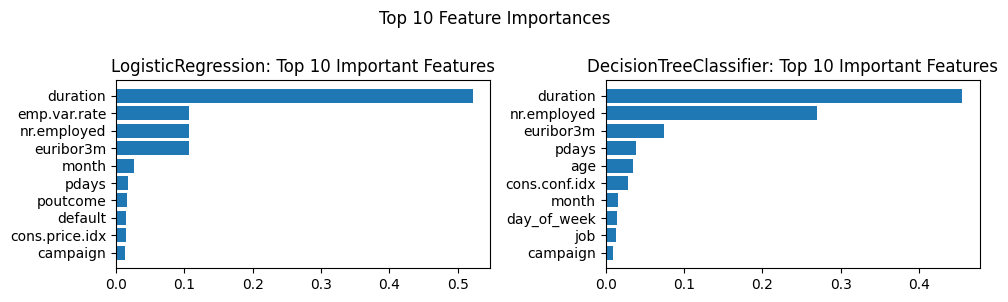

In [77]:
# plot all features in 3-columns format
cols = 2
rows = len(models) // cols

fig, axes = plt.subplots(rows, cols, figsize=(Config.PAGE_WIDTH, 5))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot feature imporatnce for models that support param coefficients
i=0
top_n=10
for name, model in models.items():
    
    feature_importances = None
    fe_model = results_tuned[name]['best_model']
    if hasattr(fe_model, 'feature_importances_'):
        # DecisionTreeClassifier
        feature_importances = fe_model.feature_importances_
    elif hasattr(fe_model, 'coef_'):
        # LogisticRegression - Use absolute values for linear models
        feature_importances = np.abs(fe_model.coef_[0])
    else:
        # KNeighborsClassifier, SVC
        pass   

    if feature_importances is not None:
        plot_single_feature_importance(name, feature_importances, X_train.columns, 
                                       top_n=top_n, print_summary=False, ax=axes[i])
        i += 1

# Hide any unused subplots
for k in range(i, len(axes)):
    fig.delaxes(axes[k])

plt.suptitle(f'Top{f" {top_n}" if top_n > 0 else ""} Feature Importances', y=1.0)

# Adjust layout to prevent overlap
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/feature_importances.png')

plt.show()

In [78]:
# best_model = results_tuned['LogisticRegression']['best_model']
# best_model = results_tuned['KNeighborsClassifier']['best_model']
# best_model = results_tuned['DecisionTreeClassifier']['best_model']
# best_model = results_tuned['SVC']['best_model']
# best_model = grid_search.best_estimator_

#### Interpreting Decision Trees

Looking at the above Feature Importances, we see that each tuned model gives different weight to the features. Decision trees are easy to interpret and see how the model came to its _decision_ for individual samples. Our tuned `DecisionTreeClassifier` was able to achieve the highest 93.46% accuracy on the training data, with allocated `max_depth=10`, out of the tuned models (likely a little over-fitted). Though it didn't score the best, but it's still instructive to visually see how it came to this.

We now show two different methods for plotting the decicions tree to understand the output:
* SciKit-learn DecisionTreeClassifier
* Dtreeviz Library

##### SciKit-Learn DecisionTreeClassifier

The standard `Scikit_learn` implementation shows a fairly unbalanced tree and traversing it's nodes, we can get an idea of how specific preidcition on new data will be made:

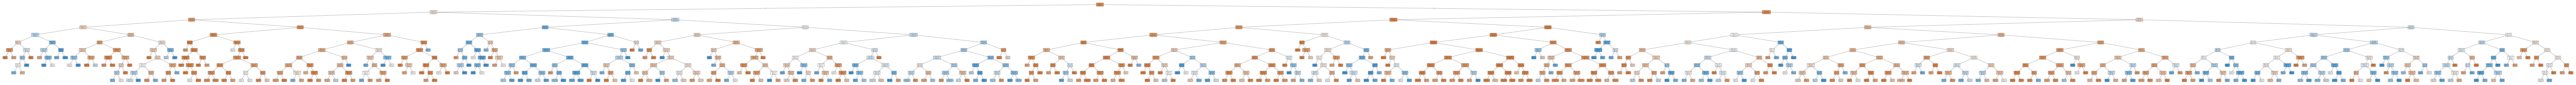

In [563]:
logging.getLogger().setLevel(logging.INFO)

dtree = results_tuned['DecisionTreeClassifier']['best_model']
plt.figure(figsize=(Config.PAGE_WIDTH * 30, 10))
label_enc.fit_transform(orig_df['y'])
plot_tree(dtree, feature_names=X_train.columns, class_names=label_enc.classes_,
          filled=True, rounded=True, fontsize=5)

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig('images/decision_tree.png')

plt.tight_layout()
plt.show()

Please open the [images/decision_tree.png](https://github.com/fazeelgm/UCB_ML_AI_PracticalApp_III/blob/main/images/decision_tree.png) separately in the browser to see the full image.

##### dtreeviz Library

For something more interesting, let's do the same exercise with the more advanced `dtreeviz` library, which provides more tools for interpretability and visualization of the training data. We'll build a `dtreeviz.model` using the fitted `DecisionTreeClassifier` from our earlier tuning exercise:

In [82]:
import dtreeviz

viz_model = dtreeviz.model(dtree,
                           X_train=X_train_scaled, y_train=y_train,
                           feature_names=X_train.columns,
                           target_name='y', class_names=label_enc.classes_)

In [545]:
# Display the visualization
# viz_model.view()

In [575]:
# if not Config.SUPPRESS_OUTPUT_FILES:
#     viz_model.view().save('images/decision_dtreeviz.svg')

Look for a specific node in the left-region of the tree to see what the model did by inspecting the Scikit tree above:

In [597]:
# Specify path criteria
selected = np.where((X_train_scaled[:,19] <= 0.47) &   # nr.employed
                    (X_train_scaled[:,10] <= 0.04) &   # duration
                    (X_train_scaled[:,12] <= 0.01) &   # pdays
                    (X_train_scaled[:,18] <= 0.02) &   # euribor3m
                    (X_train_scaled[:,9] <= 0.38) &    # day_of_week
                    (X_train_scaled[:,8] > 0.5) &      # month
                    (X_train_scaled[:,11] <= 0.03) &   # campaign
                    (X_train_scaled[:,0] > 0.29))      # age
sel = selected[0][1]

print(f'Selected row: {sel}')
# for i, col in enumerate(X_train.iloc[sel].keys()):
#     print(i, col, X_train.iloc[sel][col])

Selected row: 4058


And visualizing it:

In [588]:
viz_model.view(x=X_train_scaled[sel], fancy=False)

We can see the path the model took to decision to classify the 4,058 sample from our training set!

In [599]:
# Save as SVG for final report
if not Config.SUPPRESS_OUTPUT_FILES:
    viz_model.view(x=X_train_scaled[sel], fancy=False).save(f'images/decision_dtreeviz_row_{sel}.svg')

The library is able to show the prediction path for this specific sample:

In [603]:
print(viz_model.explain_prediction_path(X_train_scaled[sel]))

0.29 <= age 
0.5 <= month 
day_of_week < 0.38
duration < 0.04
campaign < 0.03
pdays < 0.01
euribor3m < 0.02
nr.employed < 0.47



As well as show the relative feature importances that led to this classification of `Yes`:

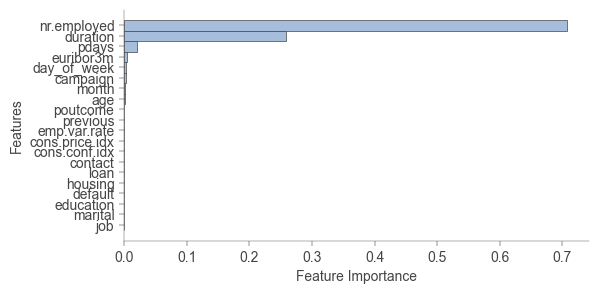

In [595]:
viz_model.instance_feature_importance(X_train_scaled[sel])

#### Permutation Importance

In [86]:
print(f'Starting permutation_importance', flush=True)
start_time = time.time()

Starting permutation_importance


In [87]:
top_n=10
feature_names = X_train.columns
p_imp = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=CV, random_state=Config.RANDOM_STATE)
p_imp_means = p_imp.importances_mean
p_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': p_imp_means})

In [88]:
print(f'Done permutation_importance: {time_secs_to_msg(time.time()-start_time)}')

Done permutation_importance: 10m 18.88s


In [89]:
if not Config.SUPPRESS_OUTPUT_FILES:  
    dfi.export(p_imp_df.head(top_n), 'images/table_permutation_imp.png')

p_imp_df.sort_values(by='Importance', ascending=False).head(top_n)

Feature  Importance
15    emp.var.rate    0.203812
18       euribor3m    0.118014
10        duration    0.048774
19     nr.employed    0.032338
8            month    0.009347
12           pdays    0.008934
16  cons.price.idx    0.004613
4          default    0.003108
7          contact    0.001966
17   cons.conf.idx    0.001894

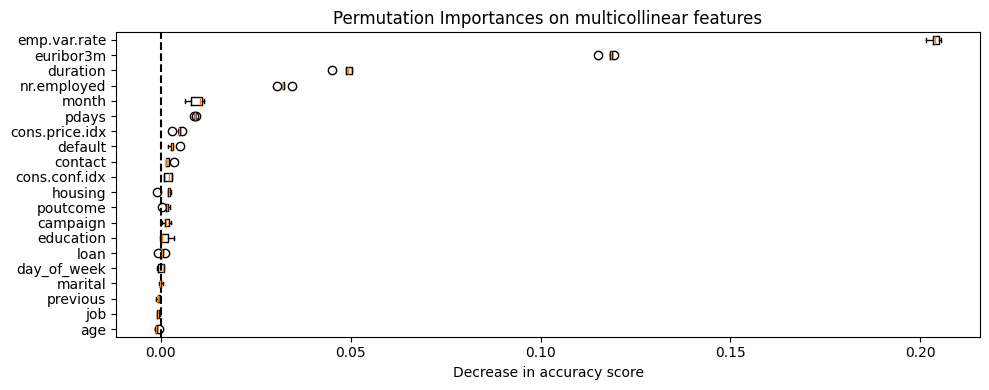

In [90]:
fig, ax = plt.subplots(figsize=(Config.PAGE_WIDTH, 4))
# plot_permutation_importance(p_imp, feature_names, p_imp_mean, ax)

perm_sorted_idx = p_imp_means.argsort()

ax.boxplot(
    p_imp.importances[perm_sorted_idx].T,
    vert=False,
    tick_labels=X.columns[perm_sorted_idx],
)
ax.axvline(x=0, color="k", linestyle="--")

ax.set_title("Permutation Importances on multicollinear features")
ax.set_xlabel("Decrease in accuracy score")
# _ = ax.figure.tight_layout()

plt.tight_layout()
plt.savefig('images/permutation_importance.png')
plt.show()

##### Questions